In [1]:
# Import libraries
import mne
import matplotlib.pyplot as plt
import numpy as np
import glob
import scipy.stats as stats
mne.set_log_level('error')  

T-test results:
p-value = 9.968835354223756e-05


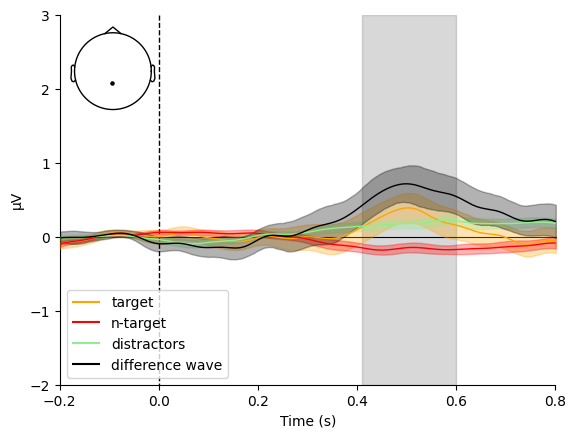

In [2]:
def perform_ttest_and_grand_average_plot(data_files, conditions, roi, tmin, tmax):
    evokeds = {}
    for idx, c in enumerate(conditions):
        evokeds[c] = [mne.read_evokeds(d)[idx] for d in data_files]
    target_evokeds = evokeds['target']
    non_target_evokeds = evokeds['n-target']
    distractor_evokeds = evokeds['distractors']
    mean_amplitude_target = []
    mean_amplitude_ntarget = []
    channels = roi
    for i in target_evokeds:
        for j in channels:
            target = i.copy().pick(j).crop(tmin=tmin, tmax=tmax)
            mean_amp_roi = target.data.mean(axis=1) * 1e6
            mean_amplitude_target.append(mean_amp_roi[0]) 
    for i in non_target_evokeds:
        for j in channels:
            nontarget = i.copy().pick(j).crop(tmin=tmin, tmax=tmax)
            mean_amp_roi = nontarget.data.mean(axis=1) * 1e6
            mean_amplitude_ntarget.append(mean_amp_roi[0])  
    # Perform independent (two-sample) t-test
    t_value, p_value = stats.ttest_ind(
        mean_amplitude_target,
        mean_amplitude_ntarget,
        equal_var=False  
    )
    print("T-test results:")
    print(f"p-value = {p_value}")   
    diff_waves = [mne.combine_evoked([evokeds['target'][subj], 
                                  evokeds['n-target'][subj],
                                 evokeds['distractors'][subj],
                                     ],
                                 weights=[1, -1, 1]
                                 ) 
              for subj in range(len(data_files))
              ]
    diff_waves
    evoked_dict = { 'target': [evokeds['target'][subj] for subj in range(len(data_files))],
                   'n-target': [evokeds['n-target'][subj] for subj in range(len(data_files))],
                   'distractors': [evokeds['distractors'][subj] for subj in range(len(data_files))],
                  'difference wave': diff_waves}
    
    color_dict = {'target':'orange', 'n-target':'red', 'distractors':'lightgreen', 'difference wave':'black'}
    linestyle_dict = {'target':'-', 'n-target':'-', 'distractors':'-', 'difference wave':'-'} 
    ch = roi
    for j in ch:
        fig, ax = plt.subplots()
        mne.viz.plot_compare_evokeds(
            evoked_dict,
            combine='mean',
            legend='lower left',
            picks=j,
            show_sensors='upper left',
            colors=color_dict,
            linestyles=linestyle_dict,
            show=False,  
            invert_y=None,
            title='', #Grand average and difference waveform of channels
            ylim=dict(eeg=[-2, 3]),
            axes=ax,  
        )
        for c in ax.collections:
            if c.get_label() == 'differnce wave' and c.get_paths():
                c.remove()
        lines = ax.get_lines()
        for line in lines:
            if 'difference wave' in line.get_label():
                line.set_alpha(1.0)
                line.set_linewidth(1.0)
            elif 'target' in line.get_label():
                line.set_alpha(1.0)
                line.set_linewidth(1.0)
            elif 'n-target' in line.get_label():
                line.set_linewidth(1.0)
            elif 'distractors' in line.get_label():
                line.set_linewidth(1.0)
            

        ax.axvspan(tmin +0.01, tmax, color='gray', alpha=0.3)
        plt.show()
if __name__ == '__main__':
    data_dir = 'D:/data/data_testing/evoked_1b'
    data_files = glob.glob(data_dir + '/*-ave.fif' )
    conditions = ['target','n-target','distractors']
    roi = ['Pz'] # 'Pz','POz','CPz'
    tmin = 0.40
    tmax= 0.60
    perform_ttest_and_grand_average_plot(data_files,conditions, roi, tmin, tmax)

Channel: Pz - p-value = 9.97e-05


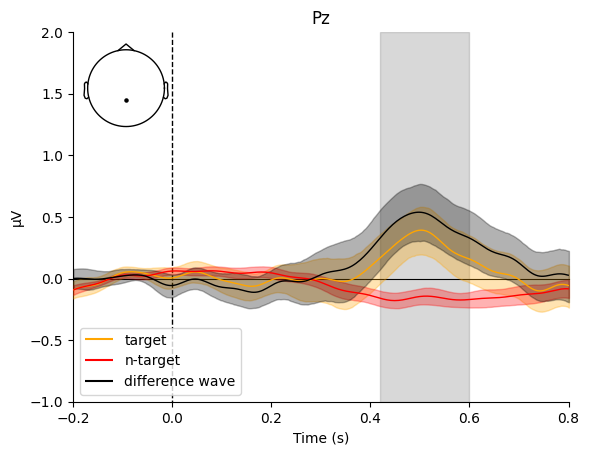

In [3]:
def perform_ttest_and_grand_average_plot(data_files, conditions, roi, tmin, tmax):
    evokeds = {}
    for idx, c in enumerate(conditions):
        evokeds[c] = [mne.read_evokeds(d)[idx] for d in data_files]
    target_evokeds = evokeds['target']
    non_target_evokeds = evokeds['n-target']
    for channel in roi:
        mean_amplitude_target = []
        mean_amplitude_ntarget = []
        for evoked in target_evokeds:
            target = evoked.copy().pick(channel).crop(tmin=tmin, tmax=tmax)
            mean_amp_roi = target.data.mean(axis=1) * 1e6
            mean_amplitude_target.append(mean_amp_roi[0])
        for evoked in non_target_evokeds:
            nontarget = evoked.copy().pick(channel).crop(tmin=tmin, tmax=tmax)
            mean_amp_roi = nontarget.data.mean(axis=1) * 1e6
            mean_amplitude_ntarget.append(mean_amp_roi[0])
        t_value, p_value = stats.ttest_ind(
            mean_amplitude_target,
            mean_amplitude_ntarget,
            equal_var=False  
        )
        print(f"Channel: {channel} - p-value = {p_value:.2e}")
        diff_waves = [
            mne.combine_evoked([evokeds['target'][subj], evokeds['n-target'][subj]], weights=[1, -1])
            for subj in range(len(data_files))
        ]
        evoked_dict = {
            'target': [evokeds['target'][subj] for subj in range(len(data_files))],
            'n-target': [evokeds['n-target'][subj] for subj in range(len(data_files))],
            'difference wave': diff_waves
        }
        color_dict = {'target': 'orange', 'n-target': 'red', 'difference wave': 'black'}
        linestyle_dict = {'target': '-', 'n-target': '-', 'difference wave': '-'}
        fig, ax = plt.subplots()
        mne.viz.plot_compare_evokeds(
            evoked_dict,
            combine='mean',
            legend='lower left',
            picks=channel,
            show_sensors='upper left',
            colors=color_dict,
            linestyles=linestyle_dict,
            show=False,
            #title=f'Grand average ERPs and difference waveform at channel {channel}',
            ylim=dict(eeg=[-1, 2]),
            axes=ax,
        )
        for line in ax.get_lines():
            if 'difference wave' in line.get_label():
                line.set_alpha(1.0)
                line.set_linewidth(1.0)
            elif 'target' in line.get_label() or 'n-target' in line.get_label():
                line.set_alpha(1.0)
                line.set_linewidth(1.0)
        ax.axvspan(tmin +0.02, tmax, color='gray', alpha=0.3)
        plt.savefig("grand_average_1b_target_n-target.png", format='png')
        plt.show()

if __name__ == '__main__':
    data_dir = 'D:/data/data_testing/evoked_1b'
    data_files = glob.glob(data_dir + '/*-ave.fif')
    conditions = ['target', 'n-target']
    roi = ['Pz']
    tmin = 0.40
    tmax = 0.60
    perform_ttest_and_grand_average_plot(data_files, conditions, roi, tmin, tmax)


Channel: Pz - p-value = 3.95e-01


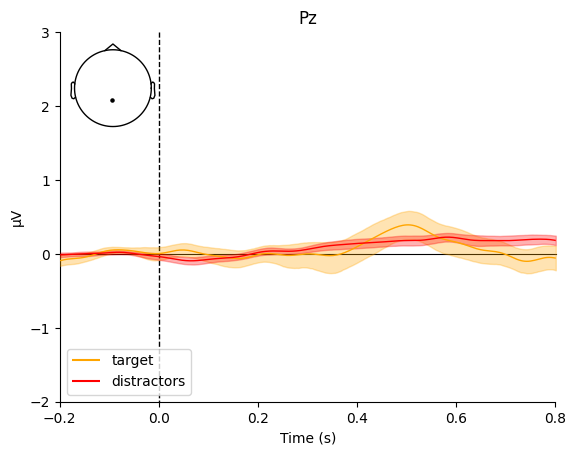

In [4]:
def perform_ttest_and_grand_average_plot(data_files, conditions, roi, tmin, tmax):
    evokeds = {}
    for idx, c in enumerate(conditions):
        evokeds[c] = [mne.read_evokeds(d)[idx] for d in data_files]
    target_evokeds = evokeds['target']
    distractor_evokeds = evokeds['distractors']
    for channel in roi:
        mean_amplitude_target = []
        mean_amplitude_distractor = []
        for i in target_evokeds:
            target = i.copy().pick(channel).crop(tmin=tmin, tmax=tmax)
            mean_amp_roi = target.data.mean(axis=1) * 1e6
            mean_amplitude_target.append(mean_amp_roi[0])
        for j in distractor_evokeds:
            distractors = j.copy().pick(channel).crop(tmin=tmin, tmax=tmax)
            mean_amp_roi = distractors.data.mean(axis=1) * 1e6
            mean_amplitude_distractor.append(mean_amp_roi[0])
        t_value, p_value = stats.ttest_ind(
            mean_amplitude_target,
            mean_amplitude_distractor,
            equal_var=False  
        )
        print(f"Channel: {channel} - p-value = {p_value:.2e}")
        #diff_waves = [
            #mne.combine_evoked([evokeds['target'][subj], evokeds['distractors'][subj]], weights=[1, -1])
            #for subj in range(len(data_files))
        #]
        evoked_dict = {
            'target': [evokeds['target'][subj] for subj in range(len(data_files))],
            'distractors': [evokeds['distractors'][subj] for subj in range(len(data_files))],
            #'difference wave': diff_waves
        }
        color_dict = {'target': 'orange', 'distractors': 'red'} # , 'difference wave': 'black'
        linestyle_dict = {'target': '-', 'distractors': '-'} #  , 'difference wave': '-'
        fig, ax = plt.subplots()
        mne.viz.plot_compare_evokeds(
            evoked_dict,
            combine='mean',
            legend='lower left',
            picks=channel,
            show_sensors='upper left',
            colors=color_dict,
            linestyles=linestyle_dict,
            show=False,
            #title=f'Grand average ERPs at channel {channel}',
            ylim=dict(eeg=[-2, 3]),
            axes=ax,
        )
        for line in ax.get_lines():
            if 'target' in line.get_label():
                line.set_alpha(1.0)
                line.set_linewidth(1.0)
            elif 'distractors' in line.get_label():
                line.set_alpha(1.0)
                line.set_linewidth(1.0)
        #ax.axvspan(tmin +0.02, tmax, color='gray', alpha=0.3)
        plt.savefig("grand_average_1b_target_distractors.png", format='png')
        plt.show()

if __name__ == '__main__':
    data_dir = 'D:/data/data_testing/evoked_1b'
    data_files = glob.glob(data_dir + '/*-ave.fif')
    conditions = ['target','n-target', 'distractors']
    roi = ['Pz']
    tmin = 0.40
    tmax = 0.60
    perform_ttest_and_grand_average_plot(data_files, conditions, roi, tmin, tmax)
